In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from src.model.model_builder import Model

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
from src.utils.config_loader import load_config
cfg = load_config("../config.yaml")
data_cfg = cfg['data']
model_cfg = cfg['model']
training_cfg = cfg['training']

In [4]:
# Initialize Model
model = Model(**model_cfg['config'], num_classes=model_cfg['num_classes']).to(device)

# Load Weights
checkpoint_path = "../dataset/experiments/model_epoch_5.pth"
try:
    model.load_weights(checkpoint_path)
    print("Weights loaded successfully!")
except Exception as e:
    print(f"Error loading weights: {e}")

model.eval()

Error loading weights: Error(s) in loading state_dict for Model:
	While copying the parameter named "net.p1.0.conv.weight", whose dimensions in the model are torch.Size([96, 3, 3, 3]) and whose dimensions in the checkpoint are torch.Size([96, 3, 3, 3]), an exception occurred : ('aten.copy_.default: got mixed torch.Tensor and DTensor, need to convert all torch.Tensor to DTensor before calling distributed operators!',).
	While copying the parameter named "net.p1.0.norm.weight", whose dimensions in the model are torch.Size([96]) and whose dimensions in the checkpoint are torch.Size([96]), an exception occurred : ('aten.copy_.default: got mixed torch.Tensor and DTensor, need to convert all torch.Tensor to DTensor before calling distributed operators!',).
	While copying the parameter named "net.p1.0.norm.bias", whose dimensions in the model are torch.Size([96]) and whose dimensions in the checkpoint are torch.Size([96]), an exception occurred : ('aten.copy_.default: got mixed torch.Tensor a

Model(
  (net): Backbone(
    (p1): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (relu): SiLU()
      )
    )
    (p2): Sequential(
      (0): Conv(
        (conv): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (relu): SiLU()
      )
      (1): C3K2(
        (conv1): Conv(
          (conv): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (relu): SiLU()
        )
        (conv2): Conv(
          (conv): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm): BatchNorm2d(384, eps=0.001, momentum=0.03, affine=True, track_run

In [7]:
# Path to your test image
image_path = "../dataset/raw/images/val/000000000139.jpg"

# Run Inference
detections = model.inference(image_path, conf_thres=0.75, iou_thres=0.45)

print(f"Detections found: {len(detections)}")
if len(detections) > 0:
    print("First detection (xyxy, conf, cls):")
    print(detections[0])

Detections found: 1
First detection (xyxy, conf, cls):
tensor([[ 49.3904, 323.8725, 126.9104, 377.2441, 398.5623,  94.0000],
        [ 14.7492, 315.8454,  94.7178, 362.6972, 397.4489,  94.0000],
        [ 48.8589, 307.9130, 121.0363, 355.6520, 396.5137,  94.0000],
        ...,
        [510.0476, 101.3017, 595.7273, 211.7633, 142.7739,  40.0000],
        [-57.7808, 462.0696,  68.7799, 567.2583, 142.6594,  62.0000],
        [214.6975, 370.6741, 313.1144, 480.3572, 141.5346,  94.0000]],
       device='cuda:0')


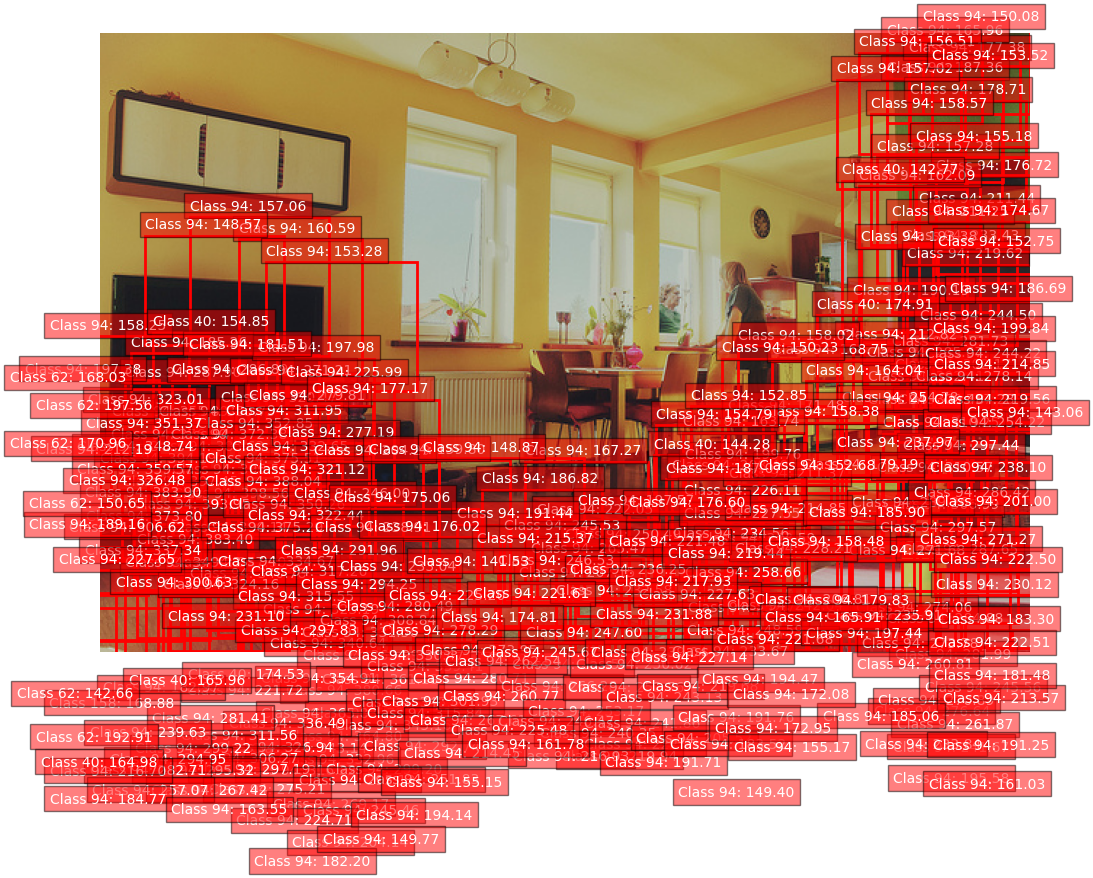

In [ ]:
def plot_detections(image_path, detections):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img)

    if len(detections) > 0:
        det_tensor = detections[0].cpu()
        
        for *xyxy, conf, cls in det_tensor:
            x1, y1, x2, y2 = xyxy
            width = x2 - x1
            height = y2 - y1
            
            # Create a Rectangle patch
            rect = patches.Rectangle(
                (x1, y1), width, height, 
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            
            # Add label
            label = f"Class {int(cls)}: {conf:.2f}"
            ax.text(
                x1, y1 - 5, label, 
                color='white', fontsize=10, 
                bbox=dict(facecolor='red', alpha=0.5)
            )

    plt.axis('off')
    plt.show()

# Visualize
plot_detections(image_path, detections)